In [1]:
import pandas as pd
import numpy as np
import random as rnd
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import Image 
from StringIO import StringIO
import pydotplus

In [2]:
def titanic(train, test):
    train_df = pd.read_csv(train)
    test_df = pd.read_csv(test)
    combine = [train_df, test_df]

    train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
    test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

    pd.crosstab(train_df['Title'], train_df['Sex'])

    for dataset in combine:
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    for dataset in combine:
        dataset['Title'] = dataset['Title'].map(title_mapping)
        dataset['Title'] = dataset['Title'].fillna(0)

    train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
    test_df = test_df.drop(['Name'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

    guess_ages = np.zeros((2,3))
    guess_ages

    for dataset in combine:
        for i in range(0, 2):
            for j in range(0, 3):
                guess_df = dataset[(dataset['Sex'] == i) & \
                                      (dataset['Pclass'] == j+1)]['Age'].dropna()

                # age_mean = guess_df.mean()
                # age_std = guess_df.std()
                # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

                age_guess = guess_df.median()

                # Convert random age float to nearest .5 age
                guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

        for i in range(0, 2):
            for j in range(0, 3):
                dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                        'Age'] = guess_ages[i,j]

        dataset['Age'] = dataset['Age'].astype(int)

    for dataset in combine:
        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1



    for dataset in combine:
        dataset['IsAlone'] = 0
        dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

    combine = [train_df, test_df]

    freq_port = train_df.Embarked.dropna().mode()[0]

    for dataset in combine:
        dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

    test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

    test_df.head(10)
    return (train_df, test_df)

In [3]:
train_df, test_df = titanic("./train.csv", "./test.csv")

In [4]:
train_df = pd.get_dummies(train_df, ["Embarked"]) #One Hot Encoding of train and test set

test_df = pd.get_dummies(test_df, ['Embarked'])

In [5]:
clf = tree.DecisionTreeClassifier(random_state=300)
params = {'max_depth': [1,2,3],                   #Hyper parameters for Randomized Search
         'min_samples_split': [2,3],
         'max_leaf_nodes': [2,3],
          'class_weight': [None, 'balanced'],
         'presort': [True, False],
         'criterion': ['gini', 'entropy'],
         'max_features': [None, 'auto', 'sqrt', 'log2']} 

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter = 255)

random_search = random_search.fit(train_df.iloc[:,1:], train_df.iloc[:,0])

clf = random_search.best_estimator_

In [6]:
prediction = random_search.predict(test_df.iloc[:, 1:])

In [7]:
def visualise_tree(model, features, classes):    
    dot_data = StringIO()
    tree.export_graphviz(model, out_file=dot_data,  
                             feature_names=features,  
                             class_names=classes,  
                             filled=True, rounded=True,  
                             special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())


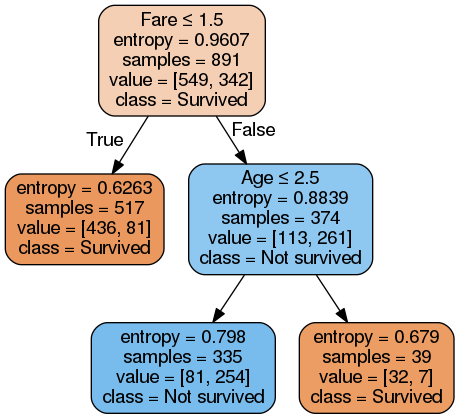

In [8]:
visualise_tree(clf, train_df.columns, ['Survived', 'Not survived'])